# Demonstrations of Orbit_Cheby Functionality

 - This notebook contains a mixture of demos of finished code, as well as WIP experimentation with ways to speed-up the code 

In [2]:
import time
import numpy as np
import scipy.stats as stats
import math
import random
from collections import defaultdict
import os
import sys
from collections import Counter
import glob 
import warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import importlib
from astropy.time import Time

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append( os.path.join(os.path.dirname(os.getcwd() ), 'orbit_cheby')  )
import nbody_reader 
import orbit_cheby
importlib.reload(nbody_reader)
importlib.reload(orbit_cheby)


<module 'orbit_cheby' from '/Users/matthewjohnpayne/Envs/orbit_cheby/orbit_cheby/orbit_cheby.py'>

## Demonstrate some aspects of the main orbit_cheby routines 
 - Here I am assuming that the "nbody_reader" routine (described in "Demonstrate_NBody_Reader_Functionality.ipynb") is available to read input data, and that we can now use the main, higher-level "orbit_cheby" routines to operate on that input nbody data, and use it to generate sets of chebyshev coefficients
 - The chebyshev coefficients are fit to "sectors" of data (e.g. 32-day chunks) and saved into suitable data structures 
 - I experiment with dictionaries, but find that numpy arrays are better/faster (surprise surprise)

#### *Create* multi-sector chebyshev dictionary: FROM JSON/DICTIONARY
 - This is an *experimental* version of a roputine to the *FUNDAMENTALLY IMPORTANT* task of converting nbody output into structured sets of chebshev coefficients
 - In this json/dictionary based approach, the data had individual lists/arrays within a dictionary for each component (e.g. a list for x-data, a list for y-data, etc).  
 - This preliminary json/dictionary version takes far too long to run (~10secs)

#### *Create* multi-sector chebyshev dictionary:  Txt/Numpy version 
 - This *WIP* version of the routine to do the *FUNDAMENTALLY IMPORTANT* task of converting nbody output into structured sets of chebshev coefficients uses a text-file/numpy-array based approach
 - This runs far more quickly (~1sec) than does the above json/dictoinary version 
 - My working assumption is that a ~1sec wait time is borderline tolerable for on-the-fly processing in an s9m/sifter routine (less important for mpchecker-processes, as the creation of the cheby's could be back-grounded in that scenario) 

In [25]:
%%time 
importlib.reload(orbit_cheby)

# Get n-body data from txt file & use to create multi_sector_cheby_dict
multi_sector_cheby_dict = orbit_cheby.generate_multi_sector_cheby_dict_from_nbody_text( 
                                    text_filepath ,
                                    minorder=17,
                                    CHECK = True )

print ( 'Number of sectors = ' , len(multi_sector_cheby_dict['sectors']) )

mscd {'MJP_TDB_init': 40000, 'sectors': [], 'unpacked_designation': '2022 AA', 'MJP_TDB_final': 59999}
Number of sectors =  623
CPU times: user 1.32 s, sys: 43.8 ms, total: 1.36 s
Wall time: 1.39 s


#### Evaluate cheby's at some times ...
 - Evaluating the cheby's will be done to allow precise positional calculations, in both the sifter- and mpchecker-scenarios. 
 - In the end this needs to be a rapid evaluation ...

### XYZ positions 
 - Here we are using a relatively low-level function (generate_XYZ_from_cheby) to find heliocentric XYZ positions using the stored data
 - It seems to be able to perform ~2e4 XYZ calculations per second (for a single object's chebyshev coeffs)

CPU times: user 1.18 s, sys: 27.4 ms, total: 1.2 s
Wall time: 1.18 s


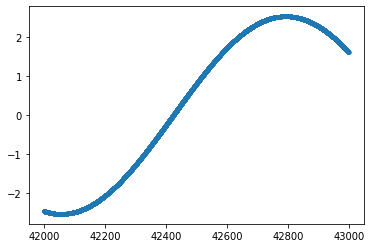

In [46]:
%%time 
importlib.reload(orbit_cheby)

nSample = 20000 

# Set up some evaluation times 
# - Astropy Time object, MJD, TDB
times = Time( np.sort(42000. + 999.*np.random.rand(nSample)), format='mjd', scale='tdb')
# Low-level call to get XYZ  ...
XYZs = orbit_cheby.generate_XYZ_from_cheby( times , multi_sector_cheby_dict )

plt.plot( times.value.tolist() , list(XYZs[:,0]) , '.' ) 

### Observational UnitVector Calculations

###### SIFTER: This UV calc is used at the time of query to (a) get the approx HP (see below) and (b) to get refined positions for precise tracklet matching 
###### MPCHECKER: This UV calc is used at the time of query to get refined positions for any approx matches extracted from the precalculated data

 - These calculations require that the positions of the observatory are provided as inputs: I.e. I want to completely separate the obs-posn stuff from the cheby evaluation calculations
 - For the sake of these demonstrations, I am going to generate a set of standardized input observatory-positions (using a silly ~circular approximation) and then provide those as inputs. 
     

In [48]:
# Create a sample of observatory-positions as inputs 
# - Note the decision to generate the obs posns in the ecliptic
# - The intent is to minimize the subsequent coordinate rotations 
#   (e..g not rotating from ecliptic-to-equatorial) 
#   when comparing the orbits to the observatory/observations
nSample = 1e4 
times = Time( 42000. + np.arange( nSample ) , format='mjd', scale='tdb')
r = 1.0 
XYZobservatory_heliocentric_ecliptic = np.array( [    r*np.cos(times.value), 
                                                      r*np.sin(times.value) , 
                                                  0.3*r*np.cos(times.value)]).T

 - In this initial experiment *BELOW* I find that it takes: 
        ~0.6s to evaluate 1e4 unit vectors for a single object using an APPROX (non-iterated) approach
        ~2s to evaluate 1e4 unit vectors for a single object using a NON-APPROX (iterated) approach 
 

In [50]:
%%time 
importlib.reload(orbit_cheby)
# Now evaluate some unit vectors 
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
_ = orbit_cheby.generate_UnitVector_from_cheby( times , 
                                               multi_sector_cheby_dict , 
                                               XYZobservatory_heliocentric_ecliptic, 
                                               APPROX = True
                                              )
print(_.shape)


(10000, 3)
CPU times: user 602 ms, sys: 8.78 ms, total: 611 ms
Wall time: 610 ms


In [51]:
%%time 
importlib.reload(orbit_cheby)
# Now evaluate some unit vectors 
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
_ = orbit_cheby.generate_UnitVector_from_cheby( times , 
                                               multi_sector_cheby_dict , 
                                               XYZobservatory_heliocentric_ecliptic, 
                                               APPROX = False
                                              )
print(_.shape)


(10000, 3)
CPU times: user 1.86 s, sys: 24.3 ms, total: 1.89 s
Wall time: 1.87 s


### Observational HP Calculations
###### SIFTER: This HP routine will be used intensively at the time a search is executed to find the APPROX HP location of an object over a series of many nights 
###### MPCHECKER: This HP routine will be used in the precalculation phase to find-and-store the HP location of an object across a series of nights 


 - Because this is a wrapper around the unitvector call, the hp call again requires that the positions of the observatory are provided as inputs: I.e. I want to completely separate the obs-posn stuff from the cheby evaluation calculations
 - For the sake of these demonstrations, I am going to use the obs-posns generated above
 
This brief experiment finds that the time to calcuate 1e4 healpix is essentially the same as the time to  generate the underlying 1e4 unitvectors

In [55]:
%%time 
importlib.reload(orbit_cheby)
# Now evaluate the HP vectors  
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
_ = orbit_cheby.generate_HP_from_cheby( times , 
                                               multi_sector_cheby_dict , 
                                               XYZobservatory_heliocentric_ecliptic, 
                                               APPROX = True
                                              )
print(_)
print(_.shape)


[1724 1710 1700 ... 1457 1429 1379]
(10000,)
CPU times: user 590 ms, sys: 8.02 ms, total: 598 ms
Wall time: 600 ms
